In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams["figure.dpi"] = 160

def remove_frame():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# Prepare data

In [3]:
n_samples = 10000
n_symbols = 5
max_length = 10

X = []
X_binary = []
y = []

for i in range(n_samples):
    x_i = np.random.randint(n_symbols, size=np.random.randint(max_length) + 1)
    len_i = len(x_i)
    
    if np.random.rand() < 0.5:
        if len_i % 2 == 0:
            x_i[:len_i//2] = x_i[len_i//2:][::-1]
        else:
            x_i[:len_i//2] = x_i[len_i//2+1:][::-1]
        y.append(1)
    else:
        if len_i % 2 == 0:
            if np.all(x_i[:len_i//2] == x_i[len_i//2:][::-1]):
                y.append(1)
            else:
                y.append(0)
        else:
            if np.all(x_i[:len_i//2] == x_i[len_i//2+1:][::-1]):
                y.append(1)
            else:
                y.append(0)

    X.append(x_i) 
            
for x_i in X:
    b = np.zeros((len(x_i), n_symbols))
    for j, x_ij in enumerate(x_i):
        b[j, x_ij] = 1
    X_binary.append(b)

In [4]:
print(X[:10])
print(y[:10])


[array([1, 3, 2, 3]), array([4, 4, 4, 0, 2, 2, 0, 2, 2]), array([3, 1, 1, 1, 1, 3]), array([1, 3, 3, 3, 3, 2, 2, 4, 4]), array([3, 1, 2, 3, 2, 3, 2, 1, 3]), array([1]), array([2, 4, 2, 4, 2, 4, 2, 4, 2]), array([3, 0, 4, 1, 1, 4, 0, 3]), array([4, 2, 2, 4]), array([4])]
[0, 0, 1, 0, 1, 1, 1, 1, 1, 1]


In [5]:
from sklearn.model_selection import train_test_split
indices = np.array(range(len(X_binary)))
train, test = train_test_split(indices)

# RNN

In [6]:
class Elman(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(Elman, self).__init__()
        self.rnn = nn.RNN(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        if self.rnn.num_layers > 1:
            hn = hn[-1, :]
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class LSTM(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class GRU(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, hn = self.rnn(x)
        out = self.fc(hn)
        return out.view(-1, 1).sigmoid()
    
class BiGRU(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(BiGRU, self).__init__()
        self.rnn = nn.GRU(num_features, num_hidden, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*num_hidden, 1)
        
        self.num_hidden = num_hidden
    
    def forward(self, x):
        out, hn = self.rnn(x)

        if self.rnn.num_layers > 1:
            hn = hn[-2:, :]
        
        out = self.fc(hn.view(-1, 2*self.num_hidden))
        return out.view(-1, 1).sigmoid()

In [7]:
test_curves = {}
models = {}

In [8]:
for model, name in [(Elman(n_symbols, 10), "elman"),
                    (Elman(n_symbols, 10, num_layers=2), "elman-stacked"),
                    (LSTM(n_symbols, 10), "lstm"),
                    (GRU(n_symbols, 10), "gru"),]:
    
    models[name] = model
    criterion = nn.BCELoss()  
    optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)  

    num_epochs = 25 
    test_loss = []

    l = 0
    for i in test:
        x_i = torch.Tensor(X_binary[i:i+1])
        y_i = torch.Tensor(y[i:i+1]).reshape((-1, 1))
        
        outputs = model(x_i)
        loss = criterion(outputs, y_i)
        l += loss       

    print('Epoch: [%d/%d], Step: Loss: %.4f' 
          % (0, num_epochs, l / len(test)))
    test_loss.append(l / len(test))

    for epoch in range(num_epochs):
        for i in train:       
            optimizer.zero_grad()

            x_i = torch.Tensor(X_binary[i:i+1])
            y_i = torch.Tensor(y[i:i+1]).reshape((-1, 1))
            outputs = model(x_i)
            loss = criterion(outputs, y_i)
            loss.backward()

            optimizer.step()

        l = 0
        for i in test:
            x_i = torch.Tensor(X_binary[i:i+1])
            y_i = torch.Tensor(y[i:i+1]).reshape((-1, 1))
            outputs = model(x_i)
            loss = criterion(outputs, y_i)
            l += loss       

        print('Epoch: [%d/%d], Step: Loss: %.4f' 
              % (epoch, num_epochs, l / len(test)))
        test_loss.append(l / len(test))
        
    test_curves[name] = np.array([v.detach().numpy() for v in test_loss])

/var/folders/7r/5l3qk64j0xgc5vs_9ldbb5r00000gn/T/ipykernel_90235/1242492534.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  x_i = torch.Tensor(X_binary[i:i+1])


Epoch: [0/25], Step: Loss: 0.7290
Epoch: [0/25], Step: Loss: 0.6234
Epoch: [1/25], Step: Loss: 0.6083
Epoch: [2/25], Step: Loss: 0.5745
Epoch: [3/25], Step: Loss: 0.5366
Epoch: [4/25], Step: Loss: 0.4931
Epoch: [5/25], Step: Loss: 0.4485
Epoch: [6/25], Step: Loss: 0.4276
Epoch: [7/25], Step: Loss: 0.4233
Epoch: [8/25], Step: Loss: 0.4116
Epoch: [9/25], Step: Loss: 0.4165
Epoch: [10/25], Step: Loss: 0.4059
Epoch: [11/25], Step: Loss: 0.4128
Epoch: [12/25], Step: Loss: 0.4012
Epoch: [13/25], Step: Loss: 0.3995
Epoch: [14/25], Step: Loss: 0.3944
Epoch: [15/25], Step: Loss: 0.3904
Epoch: [16/25], Step: Loss: 0.3856
Epoch: [17/25], Step: Loss: 0.3816
Epoch: [18/25], Step: Loss: 0.3733
Epoch: [19/25], Step: Loss: 0.3647
Epoch: [20/25], Step: Loss: 0.3478
Epoch: [21/25], Step: Loss: 0.3415
Epoch: [22/25], Step: Loss: 0.3416
Epoch: [23/25], Step: Loss: 0.3362
Epoch: [24/25], Step: Loss: 0.3280
Epoch: [0/25], Step: Loss: 0.6843
Epoch: [0/25], Step: Loss: 0.6218
Epoch: [1/25], Step: Loss: 0.6175

In [9]:
test_curves

{'elman': array([0.729022  , 0.6233986 , 0.60831213, 0.57450294, 0.53662723,
        0.4931259 , 0.44847545, 0.42757338, 0.42328003, 0.4116422 ,
        0.4164659 , 0.40590167, 0.4127767 , 0.4012448 , 0.39945677,
        0.39441806, 0.39036015, 0.3855512 , 0.38162437, 0.37331918,
        0.36471114, 0.34775057, 0.34151742, 0.34155792, 0.3362138 ,
        0.3279702 ], dtype=float32),
 'elman-stacked': array([0.6842519 , 0.621831  , 0.617524  , 0.60863006, 0.6038599 ,
        0.5754551 , 0.520092  , 0.4727862 , 0.4174254 , 0.40934867,
        0.40113202, 0.3917999 , 0.38555488, 0.38094568, 0.37857318,
        0.37097985, 0.36614454, 0.33930603, 0.3217469 , 0.31451127,
        0.30996704, 0.3401997 , 0.32513696, 0.3198025 , 0.29936543,
        0.30774012], dtype=float32),
 'lstm': array([0.6861933 , 0.62565583, 0.5456856 , 0.4302165 , 0.3538215 ,
        0.31064144, 0.27603096, 0.25316384, 0.23849396, 0.2299826 ,
        0.22440971, 0.21819717, 0.2101414 , 0.20670986, 0.20181057,
        

# Plots

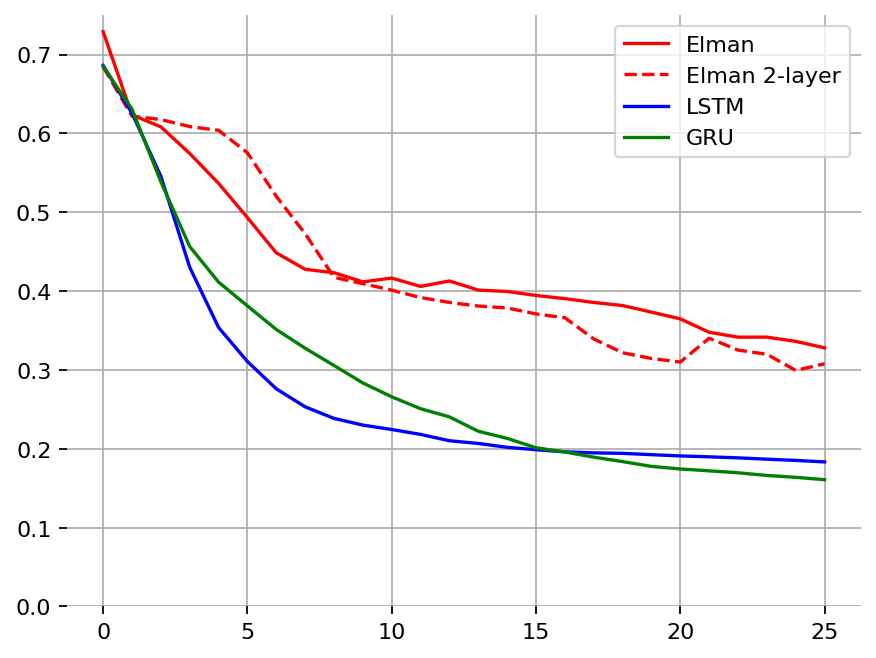

In [10]:
plt.plot(range(num_epochs+1), test_curves["elman"], c="r", label="Elman")
plt.plot(range(num_epochs+1), test_curves["elman-stacked"], "r--", label="Elman 2-layer")
plt.plot(range(num_epochs+1), test_curves["lstm"], c="b", label="LSTM")
plt.plot(range(num_epochs+1), test_curves["gru"], c="g", label="GRU")
plt.ylim(0,0.75)
plt.grid()
plt.legend()
remove_frame()
plt.savefig("palindrome-1.png")
plt.show()

In [11]:
X_test = []
y_test = []

for i in range(25000):
    x_i = np.random.randint(n_symbols, size=np.random.randint(2*max_length) + 1)
    len_i = len(x_i)
    
    if np.random.rand() < 0.5:
        if len_i % 2 == 0:
            x_i[:len_i//2] = x_i[len_i//2:][::-1]
        else:
            x_i[:len_i//2] = x_i[len_i//2+1:][::-1]
        y_test.append(1)
    else:
        if len_i % 2 == 0:
            if np.all(x_i[:len_i//2] == x_i[len_i//2:][::-1]):
                y_test.append(1)
            else:
                y_test.append(0)
        else:
            if np.all(x_i[:len_i//2] == x_i[len_i//2+1:][::-1]):
                y_test.append(1)
            else:
                y_test.append(0)

    X_test.append(x_i) 

In [12]:
X_binary_test = []

for x_i in X_test:
    b = np.zeros((len(x_i), n_symbols))
    for j, x_ij in enumerate(x_i):
        b[j, x_ij] = 1
    X_binary_test.append(b)

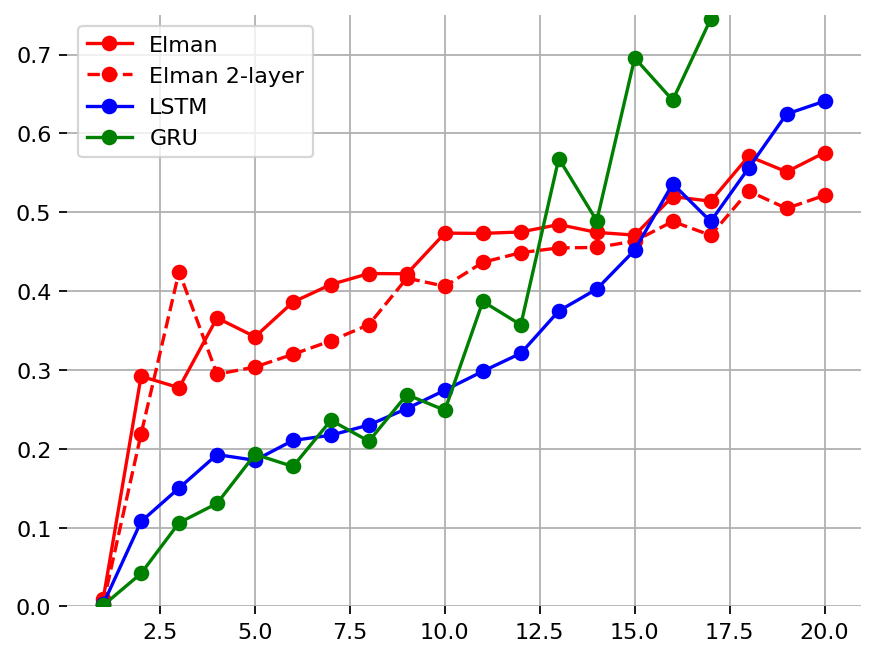

In [13]:
model = models["elman"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1]).reshape((-1, 1))
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="r", marker="o", label="Elman")

model = models["elman-stacked"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1]).reshape((-1, 1))
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, "r--", marker="o", label="Elman 2-layer")

model = models["lstm"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1]).reshape((-1, 1))
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="b", marker="o", label="LSTM")

model = models["gru"]
l = np.zeros(2*max_length)
counters = np.zeros(2*max_length)

for i in range(len(X_test)):
    x_i = torch.Tensor(X_binary_test[i:i+1])
    y_i = torch.Tensor(y_test[i:i+1]).reshape((-1, 1))
    outputs = model(x_i)
    loss = criterion(outputs, y_i)
    l[len(x_i[0])-1] += loss   
    counters[len(x_i[0])-1] += 1
    
plt.plot(range(1,2*max_length+1),l/counters, color="g", marker="o", label="GRU")

plt.legend()
plt.ylim(0,0.75)
plt.grid()
remove_frame()
plt.savefig("length-4.png")
plt.show()

Training Elman network with 1 layers...
Training Elman network with 2 layers...
Training Elman network with 3 layers...
Training Elman network with 4 layers...
Training Elman network with 5 layers...


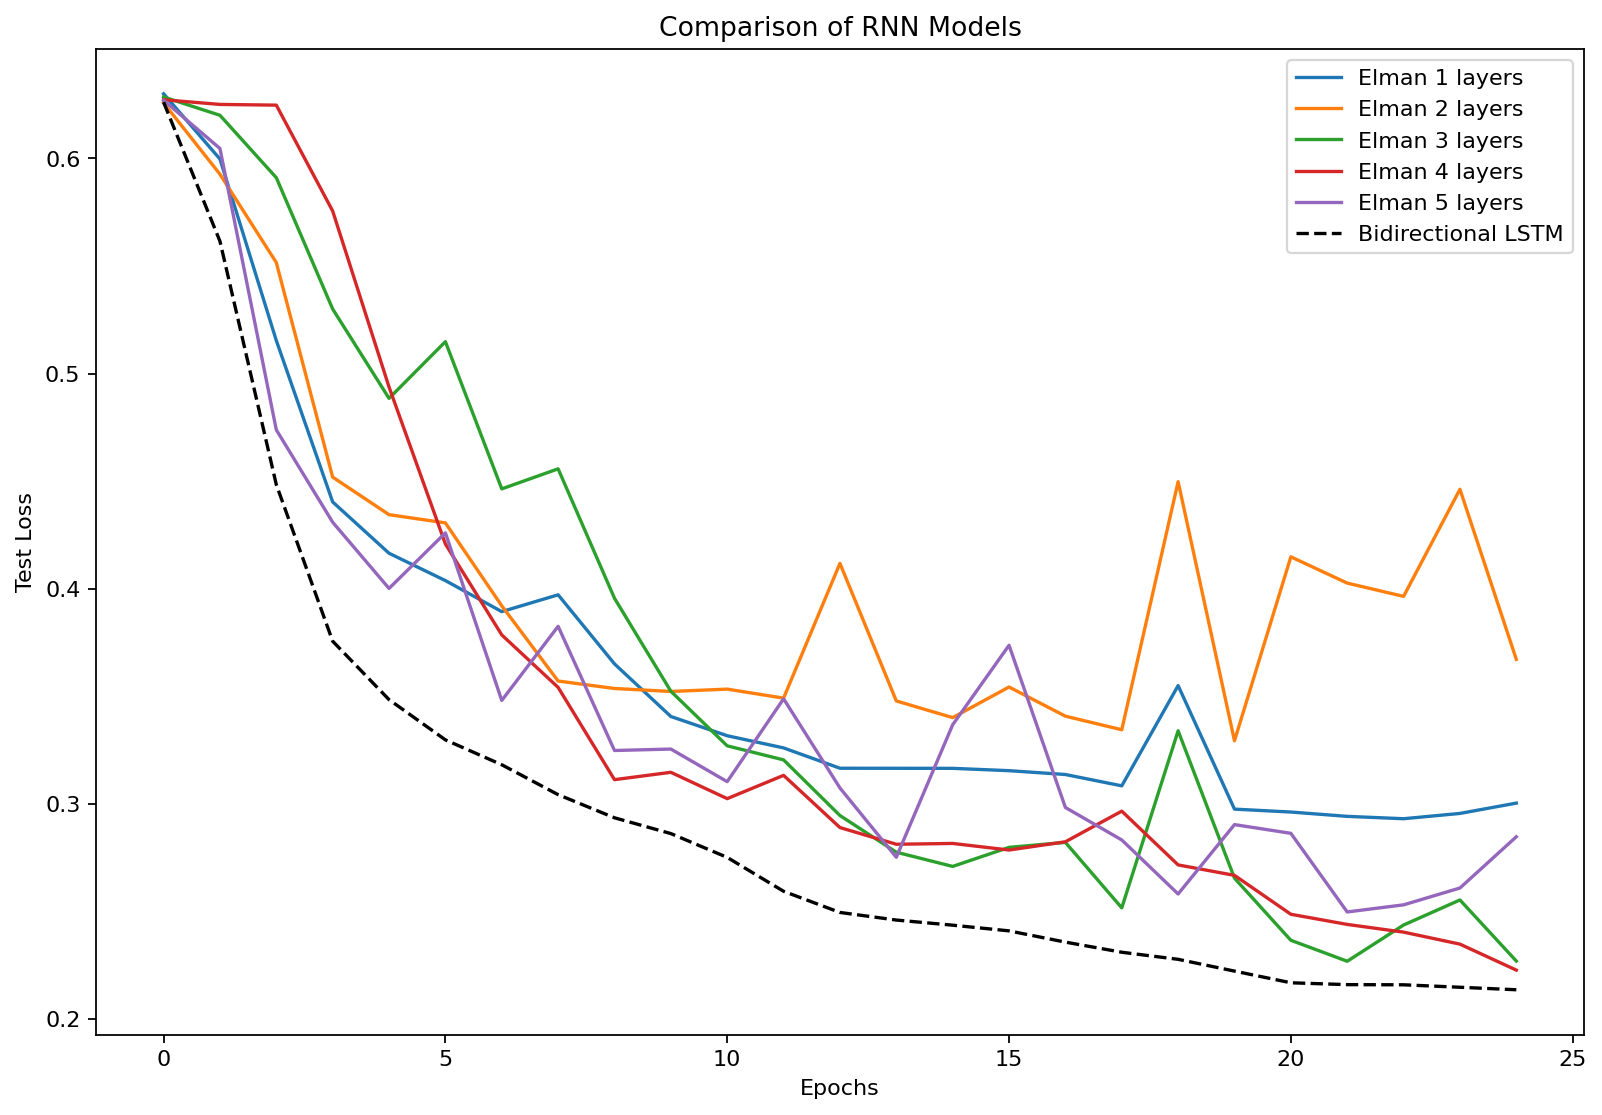

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

class Elman(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(Elman, self).__init__()
        self.rnn = nn.RNN(num_features, num_hidden, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(num_hidden, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  
        return torch.sigmoid(out)

class BiLSTM(nn.Module):
    def __init__(self, num_features, num_hidden, num_layers=1):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(num_features, num_hidden, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*num_hidden, 1)  
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return torch.sigmoid(out)

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=25):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        for x, y in zip(X_train, y_train):
            x, y = torch.Tensor(x).unsqueeze(0), torch.Tensor([y]).unsqueeze(0)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x, y in zip(X_test, y_test):
                x, y = torch.Tensor(x).unsqueeze(0), torch.Tensor([y]).unsqueeze(0)
                output = model(x)
                loss = criterion(output, y)
                test_loss += loss.item()
        test_losses.append(test_loss / len(X_test))
    
    return test_losses

indices = np.array(range(len(X_binary)))
train_indices, test_indices = train_test_split(indices, test_size=0.2)

layer_configs = [1, 2, 3, 4, 5]
elman_results = {}
for layers in layer_configs:
    model = Elman(n_symbols, 10, num_layers=layers)
    print(f"Training Elman network with {layers} layers...")
    losses = train_model(model, [X_binary[i] for i in train_indices], [y[i] for i in train_indices], [X_binary[i] for i in test_indices], [y[i] for i in test_indices])
    elman_results[layers] = losses

bi_lstm_model = BiLSTM(n_symbols, 10)
bi_lstm_losses = train_model(bi_lstm_model, [X_binary[i] for i in train_indices], [y[i] for i in train_indices], [X_binary[i] for i in test_indices], [y[i] for i in test_indices])

plt.figure(figsize=(12, 8))
for layers, losses in elman_results.items():
    plt.plot(losses, label=f'Elman {layers} layers')
plt.plot(bi_lstm_losses, label='Bidirectional LSTM', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()
plt.title('Comparison of RNN Models')
plt.show()


In [23]:
average_losses = {layers: np.mean(losses) for layers, losses in elman_results.items()}

best_layer = min(average_losses, key=average_losses.get)
best_loss = average_losses[best_layer]

print(f"The best Elman network configuration is with {best_layer} layers, achieving an average test loss of {best_loss:.4f}.")

for layers, avg_loss in average_losses.items():
    print(f"Average test loss for Elman network with {layers} layers: {avg_loss:.4f}")

average_bi_lstm_loss = np.mean(bi_lstm_losses)
print(f"Average test loss for BiLSTM: {average_bi_lstm_loss:.4f}")

if average_bi_lstm_loss < best_loss:
    print("BiLSTM performs better than the best Elman configuration.")
else:
    print("The best Elman configuration performs better than or equally to BiLSTM.")


The best Elman network configuration is with 5 layers, achieving an average test loss of 0.3186.
Average test loss for Elman network with 1 layers: 0.4010
Average test loss for Elman network with 2 layers: 0.4293
Average test loss for Elman network with 3 layers: 0.3510
Average test loss for Elman network with 4 layers: 0.3455
Average test loss for Elman network with 5 layers: 0.3186
Average test loss for BiLSTM: 0.2960
BiLSTM performs better than the best Elman configuration.
